# Lab 2d: Fun With Principle Component Analysis (PCA)
In this lab, we'll explore the [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) of a standard matrix in chemical systems: the stoichiometric matrix $\mathbf{S}$. The stoichiometric matrix is the digital representation of a chemical reaction system.

#### What is a stoichiometric matrix?
Suppose we have a set of chemical (or biochemical) reactions $\mathcal{R}$ involving the chemical species (metabolite) set $\mathcal{M}$. Then, the stoichiometric matrix is a $\mathbf{S}\in\mathbb{R}^{|\mathcal{M}|\times|\mathcal{R}|}$ matrix that holds the stoichiometric coefficients $\sigma_{ij}\in\mathbf{S}$ such that:
* $\sigma_{ij}>0$: Chemical species (metabolite) $i$ is _produced_ by reaction $j$. Species $i$ is a product of reaction $j$.
* $\sigma_{ij} = 0$: Chemical species (metabolite) $i$ is not connected with reaction $j$
* $\sigma_{ij}<0$: Chemical species (metabolite) $i$ is _consumed_ by reaction $j$. Species $i$ is a reactant of reaction $j$.

We'll explore some stoichiometric matrices downloaded from [the BiGG Models database from the Palsson lab at UCSD](http://bigg.ucsd.edu/), and see what they are telling us using [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).

#### What is PCA?
Imagine that we have $m$-dimensional features $\mathbf{x}\in\mathbb{R}^{m}$ that we want to reduce to a set of new composite feature vectors with a smaller dimension $\mathbf{y}\in\mathbb{k}$ where $k\ll{m}$. We can do that using a special transformation matrix $\mathbf{P}\in\mathbb{R}^{k\times{m}}$
$$
\begin{equation}
\mathbf{y} = \mathbf{P}\cdot\mathbf{x}
\end{equation}
$$
The rows of $\mathbf{P}$ are a set of transformation vectors $\phi^{\top}_{i}\in\mathbb{R}^{1\times{m}}$ that _convert_ the features in $\mathbf{x}$ into the $y_{i}\,\text{for}\,i=1,2,\dots{k}$ components of the new compostite feature vector:
$$
\begin{equation}
y_{i} = \phi_{i}^{\top}\cdot\mathbf{x}\quad\text{for}\,i=1,2,\dots,k
\end{equation}
$$
Wow, that sounds great! We can take high-dimensional things and reduce them down to only a few dimensions. What are these magical transformation vectors $\phi_{i}^{\top}$? The
$\texttt{TLDR}$ version of this story is that they are the eigenvectors of the covariance matrix corresponding to the largest $k$-eigenvalues, and this magical transformation is called [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). We are going to build one of these magical transformations today!

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (10 min)__: Let's take 10 minutes to review the dataset we'll explore today and set up some values we'll use in the other tasks. We'll load the data and do some initial _data munging_ (also called [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling)) to get the dataset in a form that we'll use in our analysis.
* __Task 2: Test some of the theoretical claims from the SVD lecture (10 min)__: In this task, let's test a few of the claims about singular value decomposition and its relationship with eigendecomposition [using the `eigen(...)` and `svd(...)` methods exported by the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen).
* __Task 3: Dimensionality reduction with Principle Component Analysis (PCA) (30 min)?__: In this task, we'll construct the matrix $\mathbf{P}$ which transforms our original feature vectors into lower dimensional composite features, and then explore some of the properties of the composite features. _Is there something interesting here?_

## Task 1: Setup, Data and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [429]:
include("Include.jl")

### Data
We developed a simple software development kit (SDK) against [the BiGG Models application programming interface at the University of California, San Diego](http://bigg.ucsd.edu/). The [BiGG Models database](http://bigg.ucsd.edu/) integrates published genome-scale metabolic networks into a single database with standardized nomenclature and structure. 
* [The BiGG models API](http://bigg.ucsd.edu/data_access) allows users to programmatically access genome-scale stoichiometric model reconstructions using a simple web API. There are `108` models of intracellular biochemistry occurring in various organisms (including humans) in the database (so far); [see here for a list of models](http://bigg.ucsd.edu/models).
* Here, we'll first explore the [core metabolic model of Palsson and coworkers](https://pubmed.ncbi.nlm.nih.gov/26443778/), which is a scaled-down model of [carbohydrate metabolism](https://en.wikipedia.org/wiki/Carbohydrate_metabolism) in _E.coli_. This model has 72 metabolites and 95 reactions. We'll then look at other models, and see what is going on with these.

We call the model download endpoint of [the BiGG models API](http://bigg.ucsd.edu/data_access) and then save the model file to disk (so we don't hit the API unless we have to). This call returns model information organized as [a Julia dictionary](https://docs.julialang.org/en/v1/base/collections/#Base.Dict) in the `model::Dict{String, Any}` variable. If a model file is saved, we use the cached file instead of making an API call.

In [431]:
model = let

    # build download endpoint -
    baseurl = "http://bigg.ucsd.edu"; # base url to download model
    modelid = "iAF1260b"; # model id to download
    path_to_saved_model_file = joinpath(_PATH_TO_DATA, "saved-model-$(modelid).jld2");

    # check: do we have a model file saved?
    model = nothing;
    if (isfile(path_to_saved_model_file) == false)
        
        endpoint = MyBiggModelsDownloadModelEndpointModel();
        endpoint.bigg_id = modelid;
        url = build(baseurl, endpoint)
        model = MyBiggModelsDownloadModelEndpointModel(url);

        # Before we move on, save this model for later (so we don't keep hitting the API)
        save(path_to_saved_model_file, Dict("model" => model));
    else
        model = load(path_to_saved_model_file)["model"];
    end
    model; # return the model (either saved, or downloaded)
end

Dict{String, Any} with 6 entries:
  "metabolites"  => Any[Dict{String, Any}("compartment"=>"e", "name"=>"D-Glucos…
  "id"           => "e_coli_core"
  "compartments" => Dict{String, Any}("c"=>"cytosol", "e"=>"extracellular space…
  "reactions"    => Any[Dict{String, Any}("name"=>"Phosphofructokinase", "metab…
  "version"      => "1"
  "genes"        => Any[Dict{String, Any}("name"=>"adhE", "id"=>"b1241", "notes…

__Stoichiometric matrix__: Next, let's build a stoichiometric matrix $\mathbf{S}$ using the metabolite and reaction records. We'll do this using nested [`for` loops](https://docs.julialang.org/en/v1/base/base/#for). 
* __Strategy__: In the outer loop, we iterate over the system's metabolites (chemical species) and select the `id` from the metabolites record for each metabolite. In the inner loop, we iterate over each reaction. For each reaction record, we ask if this reaction has an entry for the current metabolite `id` value; if it does, we grab the stoichiometric coefficient $\sigma_{ij}$ corresponding to this metabolite and reaction.

In [433]:
S = let

    # get some data from the model -
    m = model["metabolites"]; # get list of metabolites
    r = model["reactions"]; # get list of reactions
    number_of_rows = length(m); # how many metabolites do we have? (rows)
    number_of_cols = length(r); # how many reactions do we have? (cols)
    S = zeros(number_of_rows,number_of_cols); # initialize an empty stoichiometric matrix

    # let's build a stm -
    for i ∈ eachindex(m)
        metabolite = m[i]["id"]; # we are checking if this metabolite is in the reaction record
        for j ∈ eachindex(r)
            reaction = r[j];
            if (haskey(reaction["metabolites"], metabolite) == true)
                S[i,j] = reaction["metabolites"][metabolite];
            end
        end
    end
    S; 
end;

We'll also consider the [z-score centered](https://en.wikipedia.org/wiki/Feature_scaling) stoichiometric matrix $\hat{\mathbf{S}}$ in which we center the columns (reactions) of the matrix. We'll save this version of the stoichiometric matrix in the `Ŝ::Array{Float64,2}` variable.

In [435]:
Ŝ = let
    
    # get some data from the system -
    m = model["metabolites"] |> length # get the number of metabolites
    r = model["reactions"] |> length # get the number of reactions
    Ŝ = zeros(m,r); # create a scaled stoichiometric matrix

    for j ∈ 1:r
        col = S[:,j]; # get the jth col (reaction)
        μⱼ = mean(col); # mean of the col
        σⱼ = std(col); # std of the col

        for i ∈ 1:m
            Ŝ[i,j] = (col[i] - μⱼ)/σⱼ
        end
    end

    Ŝ
end;

Finally, compute the covariance array $\hat{\mathbf{\Sigma}}$, which will be a $|\mathcal{R}|\times|\mathcal{R}|$ symmetric array. We calculate this array using [the `cov(...)` method exported by the `Statistics.jl` package](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov). 
* __Note__: We can compute $\mathbf{\Sigma}$ using either the regular stoichiometric matrix $\mathbf{S}$ or the centerted version $\hat{\mathbf{S}}$. These _should_ give _similar_ PCA results, but they are different arrays, i.e., the variance will be `1` in the centered case. For now, let's use the regular array.

In [437]:
Σ̂ = cov(S) # covariance of the stoichiometric array (for now, use the regular S)

95×95 Matrix{Float64}:
  0.0702269     0.0        -0.0140845  …  0.0       0.0        0.0
  0.0           0.056338    0.0           0.0       0.0        0.0422535
 -0.0140845     0.0         0.028169      0.0       0.0        0.0
  0.028169      0.0         0.0           0.0       0.0        0.0
  0.0140845     0.0         0.0           0.0       0.0        0.0
  0.0140845     0.028169    0.0        …  0.0       0.0        0.056338
  0.0140845     0.0         0.0           0.0       0.0        0.0
  0.0           0.0         0.0           0.0       0.0        0.0
  0.0140845     0.0         0.0           0.0       0.0        0.0
  0.0138889     0.0         0.0           0.0       0.0        0.028169
  0.0           0.0         0.0        …  0.0       0.0        0.0
  0.028169      0.0         0.0           0.0       0.0        0.0
  0.0140845     0.0         0.0           0.0       0.0       -0.0140845
  ⋮                                    ⋱                      
 -0.000195618   0.0  

## Task 2: Let's test some of the theoretical claims from the SVD lecture
In this task, let's test a few of the claims about singular value decomposition. The singular Value Decomposition (SVD) decomposes a matrix $\mathbf{A}\in\mathbb{C}^{n\times{m}}$ into three distinct matrices, $\mathbf{A} = \mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top}$. The matrices $\mathbf{U}$ and $\mathbf{V}$  are orthogonal matrices containing the left and right singular vectors, respectively, while the $\mathbf{\Sigma}$ is a diagonal matrix containing the singular values. We'll
explore three claims: 
* __Claim 1__: Left singular vectors are the eigenvectors of matrix product $\mathbf{S}\mathbf{S}^{\top}$ (or the product $\mathbf{S}^{\top}\mathbf{S}$ for the right-singular vectors).
* __Claim 2__: The singular vectors of a symmetric real-valued positive definite matrix such as the covariance matrix $\mathbf{\Sigma}$ are just the eigenvectors of $\mathbf{\Sigma}$.
* __Claim 3__: The singular values of a matrix $\mathbf{S}$ are the square roots of the non-zero eigenvalues of either $\mathbf{S}\mathbf{S}^{\top}$ or $\mathbf{S}^{\top}\mathbf{S}$.

### Claim 1: Singular vectors are eigenvectors of matrix products
The singular vectors contained in the columns of the $\mathbf{U}$ and $\mathbf{V}$ are the eigenvectors of the matrix product $\mathbf{S}\mathbf{S}^{\top}$ and $\mathbf{S}^{\top}\mathbf{S}$, respectively for the _non-zero_ eigenvalues. We start by testing the left singular matrix $\mathbf{U}$ by computing the SVD of the matrix product $\mathbf{S}\mathbf{S}^{\top}$ and compare it to the eigendecomposition. 
* _What about the right singular vectors?_ We'll leave you to the comparison of the eigenvectors of the product $\mathbf{S}^{\top}\mathbf{S}$ to the right-singular vectors to you (maybe a fun weekend project?)

In [440]:
U₁,Σ₁,VT₁ = let

    # compute SVD -
    A = S*transpose(S); # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A? (this should be square)
    F = svd(A, full = true, alg=LinearAlgebra.QRIteration()); # notice we are using QR iteration!
    U = F.U;
    Σ = F.S;
    V = F.V;

    U, Σ, V
end;

Next, compute the eigendecomposition for the matrix $\mathbf{S}\mathbf{S}^{\top}$ using [the `eigen(...)` method exported by the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen). We'll store the eigenvalue data in the diagonal `Λ₁::Array{Float64,2}` matrix, and 
the eigenvector data in the `V₁::Array{Float64,2}` matrix.

In [442]:
Λ₁,V₁ = let

    # initialize -
    A = S*transpose(S); # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A?
    Λ = Matrix{Float64}(1.0*I, n, n); # builds the I matrix, we'll update with λ -
    
    # Decompose using the built-in function
    F = eigen(A);   # eigenvalues and vectors in F of type Eigen (biggest first)
    λ = F.values;   # vector of eigenvalues
    V = F.vectors;  # n x n matrix of eigenvectors, each col is an eigenvector

    # package the eigenvalues into Λ -
    reverse!(λ)
    for i ∈ 1:n
        Λ[i,i] = λ[i];
    end

    Λ,V
end;

Compare the left singular vectors with the eigenvectors. If the vectors are the same then $\left<\mathbf{u}_{i},\mathbf{v}_{j}\right> = \delta_{ij}$ where $\mathbf{u}_{i}$ denotes the ith left singular vector, $\mathbf{v}_{i}$ denotes the ith eigenvector, and $\delta_{ij}$ denotes [the Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta#). Specify an index $i$ to look at and see the result stored in the `δ₁::Float64` variable:

In [444]:
δ₁ = let 
    index = 11; # index of the vector we want to look at 
    uᵢ = U₁[:,index];
    vᵢ = V₁[:,end - (index-1)]; # DQ: why are we going from the end?
    dot(uᵢ,vᵢ) # inner product
end

0.9999999999999984

### Claim 2: Singular vectors of a symmetric real positive definite matrix are the eigenvectors
In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the left and right singular vectors align with the eigenvectors. Let's test this claim by first computing the singular value decomposition of the covariance matrix $\mathbf{\Sigma}$, then we'll compute the eigenvalues and eigenvectors of $\mathbf{\Sigma}$, and finally, we'll compare the singular vectors with the eigenvectors.

In [446]:
U₂,Σ₂,VT₂ = let

    # compute SVD -
    A = Σ̂; # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A? (this should be square)
    F = svd(A, full = true, alg=LinearAlgebra.QRIteration()); # notice we are using QR iteration!
    U = F.U;
    Σ = F.S;
    V = F.V;

    U, Σ, V
end;

Next, compute the eigendecomposition of the covariance matrix $\mathbf{\Sigma}$ using [the `eigen(...)` method exported by the `LinearAlgebra.jl` package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.eigen). We'll store the eigenvalue data in the diagonal `Λ₂::Array{Float64,2}` matrix, and 
the eigenvector data in the `V₂::Array{Float64,2}` matrix.

In [448]:
Λ₂,V₂ = let

    # initialize -
    A = Σ̂; # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A?
    Λ = Matrix{Float64}(1.0*I, n, n); # builds the I matrix, we'll update with λ -
    
    # Decompose using the built-in function
    F = eigen(A) ;   # eigenvalues and vectors in F of type Eigen (biggest first)
    λ = F.values;   # vector of eigenvalues
    V = F.vectors;  # n x n matrix of eigenvectors, each col is an eigenvector

    # package the eigenvalues into Λ -
    reverse!(λ)
    for i ∈ 1:n
        Λ[i,i] = λ[i];
    end

    Λ,V
end;

Compare the left singular vectors with the eigenvectors. If the vectors are the same then $\left<\mathbf{u}_{i},\mathbf{v}_{j}\right> = \delta_{ij}$ where $\mathbf{u}_{i}$ denotes the ith left singular vector, $\mathbf{v}_{i}$ denotes the ith eigenvector, and $\delta_{ij}$ denotes [the Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta#). Specify an index $i$ to look at and see the result stored in the `δ₂::Float64` variable:

In [450]:
δ₂ = let 
    index = 4; # index of the vector we want to look at 
    uᵢ = U₂[:,index];
    vᵢ = V₂[:,end - (index-1)]; # DQ: why are we going from the end?
    dot(uᵢ,vᵢ)
end

-0.9999999999999989

### Claim 3: Connection between singular values and eigenvalues
The singular values of a matrix $\mathbf{A}$ are the square roots of the non-zero eigenvalues of either $\mathbf{A}\mathbf{A}^{\top}$ or $\mathbf{A}^{\top}\mathbf{A}$, establishing a direct connection between these two values. In cases where $\mathbf{A}$ is symmetric (square) and positive definite (positive eigenvalues), the singular values correspond directly to the absolute values of the eigenvalues.

In [452]:
U₃,Σ₃,VT₃ = let

    # compute SVD -
    A = S; # matrix we want to decompose
    (n,m) = size(A); # what is the dimension of A? (this should be square)
    F = svd(A, full = true, alg=LinearAlgebra.QRIteration()); # notice we are using QR iteration!
    U = F.U;
    Σ = F.S;
    V = F.V;

    U, Σ, V
end;

Next, let's compare the singular values of $\mathbf{S}$ with the eigenvalues of $\mathbf{S}\mathbf{S}^{\top}$. If _claim 3_ is true, then we should see $\sigma_{i}=\sqrt{\lambda_{i}}$ for all non-zero eigenvalues. For this test, we'll use [the `@assert` macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert)

In [454]:
let
    λ = diag(Λ₁); # get list of eigenvalues of SS^T
    σ = Σ₃; # signular values of S
    index = 10;
    @assert σ[index] ≈ √λ[index]
end

## Task 3: Dimensionality reduction with Principle Component Analysis (PCA)
In this task, let's construct the transformation matrix $\mathbf{P}$ which transforms the original feature vectors into a lower dimension, i.e., it takes a vector that was originally $m$-dimensional and reduces it to $k$-dimensions, where $k\ll{m}$ such the reconstruction error is minimized (and the variance was captured). The new features (composite features) are saved in the $|\mathcal{M}|\times{k}$ composite feature $\mathbf{Y}$-matrix and the transformation matrix is stored in the `P::Array{Float64,2}` variable.

In [456]:
Y, P = let

    # initialize -
    k = 2; # reduced dimension
    number_of_cols = size(U₂,2);
    P = zeros(k,number_of_cols); # transformation matrix

    # build P -
    for i ∈ 1:k
        for j ∈ 1:number_of_cols
            P[i,j] = U₂[i,j];
        end
    end
    Y = P*transpose(S) |> transpose |> Matrix, P
end;

### Visualize the reduced column space
We reduced the column space (the set of reactions) from $|\mathcal{R}|$-dimensional to `k = 2` dimensional. We can now plot the composite features and look at some of their properties. `Unhide` the code block below to see how we plotted the centroid and the values of the composite vector.
* __Summary__: You'll see a different pattern depending on your chosen metabolic network. However, generally, you should expect to see a bunch of points clustered around the centroid and then points far away from the centroid. We hypothesize that the outlier points, i.e., far away from the centroid, represent _important_ data. 

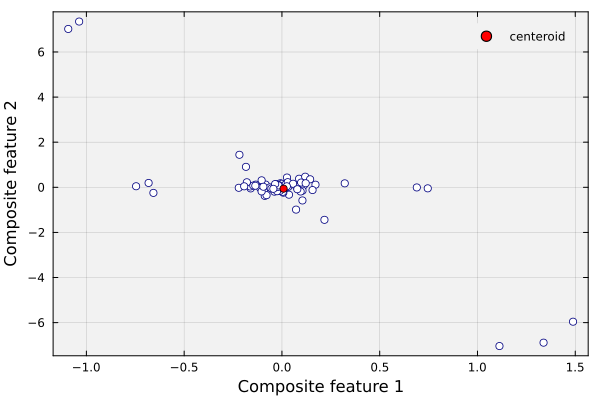

In [458]:
let

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    c = mean(y,dims=1); # compute the centroid -
    scatter!(y[:,1], y[:,2], label="", c=:white, msc=:navy)
    scatter!([c[1]],[c[2]], ms=4, c=:red, label="centeroid")
    xlabel!("Composite feature 1", fontsize=18)
    ylabel!("Composite feature 2", fontsize=18)
end

Following the hypothesis, let's compute the distance away from the centroid and sort these distances from high to low. We'll store the indexes of the sorted metabolites in the `î::Array{Int64,1}` array, while the unsorted distances are stored in the `distance_array::Array{Float64,1}` array. 

In [460]:
î, distance_array = let

    # initialize -
    c = mean(y,dims=1); # compute the centroid
    d = Euclidean(); # distance metric
    number_of_rows = size(y,1); # number of rows 
    distance_array = Array{Float64,1}(undef, number_of_rows); # storage

    # let's process each row, and compute its distance from the centroid
    for i ∈ 1:number_of_rows
        distance_array[i] = d(y[i,:],c)^2; # how far away of the point from the centroid?
    end

    # let's sort this from largest to smallest distance
    î = sortperm(distance_array, rev=true); # what does rev=true do?
    
    # return to caller
    î, distance_array
end;

Let's use the `î::Array{Int64,1}` array to look up what the `outlier` metabolites are in the metabolites field of the `model::Dict{String, Any}` dictionary. Maybe they have some critical shared functionality in the system?
* `Unhide` the code block below to see how we constructed a table holding the `outlier` metabolite information using [the `pretty_table(...)` method exported by the `PrettyTables.jl` package](https://github.com/ronisbr/PrettyTables.jl). The `logscore` field is [the `log10(...)` transformed](https://docs.julialang.org/en/v1/base/math/#Base.log10) distance.

In [479]:
let
    number_of_rows_we_want_to_see = 10;
    df = DataFrame();

    for j ∈ 1:number_of_rows_we_want_to_see

        k = î[j]; # index of metabolite
        name = model["metabolites"][k]["name"]; # name symbol of that metabolite
        id = model["metabolites"][k]["id"]; # id symbol of that metabolite
        connections = findall(σᵢ -> σᵢ ≠ 0.0, S[k, :]) |> length; # how many connections?
        
        row_df = (
            i = k,
            id = id,
            name = name,
            connections = connections, 
            logscore = log10(distance_array[k])
        );
        push!(df, row_df);
    end
    pretty_table(df, tf=tf_simple)
end

======== ========= ======================================================= ============= =============
      i        id                                                    name   connections     logscore 
  Int64    String                                                  String         Int64      Float64 
======== ========= ======================================================= ============= =============
      7     h2o_c                                                 H2O H2O            18      1.74826
     55     atp_c                                       ATP C10H12N5O13P3            13      1.71071
     51     adp_c                                       ADP C10H12N5O10P2            12      1.69836
     30      pi_c                                               Phosphate            12      1.68486
      9       h_c                                                      H+            35      1.56807
     19   nadph_c   Nicotinamide adenine dinucleotide phosphate - reduced            